# Exercise 5

## Preliminaries

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,num_workers=1)

In [12]:
#Converts label idx (n labels total) into one-hot encoding
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx, 1)

    return onehot

## Basics/Repetition  of VAE

In the lecture we have shown that $$\log p^*(x^{(i)}) \ge  -  D_{KL}[p_E(z \mid x^{(i)}) \| p(z)] +\mathbb{E}_{z\sim p_E(z \mid x^{(i)})} [\log p_D (x^{(i)} \mid z)] = -\mathcal{L}(D, E, x^{(i)}),$$
where $x^{(i)}\in\mathbb{R}^D$ is the $i$-th training instance (since the pixel values of MNIST images are in the range 0...1, we even have $x^{(i)}\in[0,1]^D$ in this case). The LHS is the logarithm of the true data distribution, and the RHS is termed the "evicence lower bound" (ELBO).

We call $p_E(z \mid x)$ the encoder and $p_D( x \mid z)$ the decoder. Both will be represented by neural networks. Our goal is to approximate $p^*(x)$ as well as possible by maximizing the ELBO or equivalently minimizing its negation. Specifically, we minimize $\mathcal{L}(D, E, x^{(i)})$ with respect to the parameters of $D$ and $E$ via gradient descent over all training instances $i$. 

In order to estimate the negative ELBO, we approximate the expectation w.r.t. $z$ by its average over $L$ instances:
\begin{align} \hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)\end{align} 
where $z^{(i,l)} \sim p_E(z \mid x^{(i)}) $. By construction of a VAE, $p_E(z \mid x^{(i)})$ is a Gaussian distribution whose mean $\mu^{(i)}=\mu_E(x^{(i)})$ and standard deviation $\sigma^{(i)}=\sigma_E(x^{(i)})$ are computed by the encoder network. For fixed $x^{(i)}$, we can draw samples $z^{(i,l)}$ from this code distribution by means of the reparametrization trick: 
$$z^{(i,l)}\sim \mathcal{N}\big(\mu^{(i)}, \text{diag}(\sigma^{(i)})^2\big) \Leftrightarrow  z^{(i,l)} = \mu^{(i)} + \epsilon_l \cdot \sigma^{(i)}$$ 
with $\epsilon_l\sim\mathcal{N}(0, \mathbb{I})$. Note that $\mu^{(i)}$, $\sigma^{(i)}$, and $\epsilon_l$ are vectors of length equal to the dimension $J$ of the latent space, and $\epsilon_l \cdot \sigma^{(i)}$ is element-wise multiplication. In practice, $L=1$ is usually sufficient.

Furthermore, we assume that the latent prior is a standard normal distribution, i.e. $p(z) = \mathcal{N}(0, \mathbb{I})$. The KL-term can then be computed analytically:
$$ D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right] = \frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) $$

Likewise, we consider $p_D(x \mid z)$ as a Gaussian distribution with mean $\mu_D(z)$ and fixed covariance matrix $\sigma_G^2\cdot \mathbb{I}$ (i.e. $\sigma_G$ is the fixed noise standard deviation):
$$ p_G(x \mid z) = \mathcal{N}\big(\mu_D(z), \sigma_G^2\cdot\mathbb{I}\big)$$
To ensure that $\mu_D(z) \in [0,1]^D$ holds for reconstructed images (without noise), the decoder's output layer should use the sigmoid activation function. The second term in the negated ELBO (the negative log-likelihood) now reduces to the squared loss:
$$-\log p_D(x^{(i)} \mid z^{(i,l)}) = \frac{||x^{(i)} - \mu_D(z^{(i,l)})||^2_2}{2 \sigma_G^2}  + \text{const.}$$
The additive constant has no influence on the training optimimum and can be dropped. $\sigma_G$ can be used as a hyperparameter to balance the two loss terms.

For a batch of samples $X = (x^{(1)}, \dots, x^{(M)})$, we finally get the negated ELBO as:
\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \frac{1}{L} \sum_{l=1}^L \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2\sigma_G^2}\Big]\end{align}
Training is performed by gradient descent on this loss.


## Task 1: Implementation of VAE and CVAE

Complete the code below. The CVAE class consists of three parts
* The Encoder class that implements $p_E (z \mid x, y)$,
* The Decoder class which implements $p_D (x \mid z, y)$ and
* The actual CVAE class that combines both encoder and decoder.

The conditioning variable $y$ holds the labels, e.g. 0...9 for MNIST digits. It is added as an additional network input, i.e. the encoder computes $\mu_E(x^{(i)}, y^{(i)})$ and $\sigma_E(x^{(i)}, y^{(i)})$, and the decoder implements `recon_x`=$\mu_D(z^{(i)}, y^{(i)})$, where $z^{(i)}$ is sampled using the reparametrization trick explained above. 

Implement all three classes. The arguments and outputs for each method are given in the docstrings. Make sure the CVAE class implements both the conditional VAE (CVAE) and the plain VAE, where the latter is obtained if the number of labels is just 1. 

In [96]:
class CVAE(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, num_labels=10, conditional=False):
        """
        Arguments:
            inp_dim (int): dimension of input,
            encoder_layer_sizes (list[int]): list of the sizes of the encoder layers,
            decoder_layer_sizes (list[int]): list of the sizes of the decoder layers,
            latent_dim (int): dimension of latent space/bottleneck,
            num_labels (int): amount of labels (important for conditional VAE),,
            conditional (bool): True if CVAE, else False

        """
        
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        self.encoder = Encoder(encoder_layer_sizes, latent_dim, num_labels, conditional)
        self.decoder = Decoder(decoder_layer_sizes, latent_dim, num_labels, conditional)
        
    def forward(self, x, c=None):
        """
        Forward Process of whole VAE/CVAE. 
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output: recon_x, means, log_var
            recon_x: see explanation on second part of estimator above,
            means: output of encoder,
            log_var: output of encoder (logarithm of variance)
        """
        batch_size = x.size(0)

        x = x.view(-1,784)
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        means,log_var=self.encoder(x,c)
        self.means,self.log_var=means,log_var
        z=self.sampling()
        recon_x=self.decoder(z,c)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return recon_x, means, log_var
        
    def sampling(self, n=2, c=None):
        """
        Arguments:
            n (int): amount of samples (amount of elements in the latent space)
            c (bool): condition
        Output:
            x_sampled: n randomly sampled elements of the output distribution
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        eps=torch.randn(n).to(device)
        x_sampled=self.means+torch.mul(eps,self.log_var)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
        return x_sampled 
    
class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):
        super(Encoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the encoder,
            latent_dim (int): dimension of latent space, i.e. dimension out output of the encoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        """
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        self.conditional=conditional
        #if conditional is true, we will have an extra input
        if conditional:
            layer_sizes[0]+=1
        modules=[]
        for i in range(len(layer_sizes)-1):
            modules.append(nn.Linear(layer_sizes[i],layer_sizes[i+1]))
            modules.append(nn.ReLU())
        self.mlp=nn.Sequential(*modules)
        self.linear_mu=nn.Linear(layer_sizes[-1],latent_dim)
        self.linear_lvar=nn.Linear(layer_sizes[-1],latent_dim)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
    
    def forward(self, x, c=None):  
        """
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output:
            means: tensor of dimension (batch_size, latent_dim),
            log_var: tensor of dimension (batch_size, latent_dim)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        x=x.view(-1,784)
        if self.conditional:
            #concatenate data and condition
            x=torch.cat([x,c.view(-1,1)],dim=1)
        x=self.mlp(x)
        means=self.linear_mu(x)
        log_vars=self.linear_lvar(x)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################        
        return means, log_vars
    
    
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):     
        super(Decoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the decoder,
            latent_dim (int): dimension of latent space, i.e. dimension out input of the decoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        Output:
            x: Parameters of gaussian distribution; only mu (see above)
        """

        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        self.conditional=conditional
        modules=[]
        #if conditional:
        #    layer_sizes[-1]+=1
        #effective layersizes start at latent dimension
        eff_layer_sizes=[latent_dim,*layer_sizes]
        for i in range(len(eff_layer_sizes)-1):
            modules.append(nn.Linear(eff_layer_sizes[i],eff_layer_sizes[i+1]))
            if i!=len(eff_layer_sizes)-2:
                modules.append(nn.ReLU())
        modules.append(nn.Sigmoid())
        self.mlp=nn.Sequential(*modules)
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
            
    def forward(self, z, c=None):
        """
        Argumetns:
            z: tensor of dimension (batch_size, latent_dim)
            c: None or tensor of dimension (batch_size, 1)
        Outputs:
            x: mu of gaussian distribution (reconstructed image from latent code z)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #if self.conditional:
            #concatenate data and condition
        #    z=torch.cat([z,c.view(-1,1)],dim=1)
        x=self.mlp(z)
        
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return x

### Loss Function

We want to minimize the negated ELBO loss:
$$\hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)$$
where $L=1$. The `loss_function` should implement this estimator, expanding the two terms as explained above.
* Implement the loss function
* Comment/explain how your code arises from the formula above.

In [38]:
# Implement the Loss function for the VAE/CVAE
def loss_function(recon_x, x, mu, log_var):
    """
    Arguments:
        recon_x: reconstruced input
        x: input,
        mu, log_var: parameters of posterior (distribution of z given x)
    """
    ################################
    # TODO: YOUR CODE STARTS BELOW #
    ################################
    #ensure same dimensions
    recon_x=recon_x.view(-1,784)
    x=x.view(-1,784)
    kl_divergence=.5*torch.sum(mu*mu+log_var.exp()-log_var-1)
    reconstruction_loss=F.binary_cross_entropy(recon_x,x,reduction='sum')
    return kl_divergence+reconstruction_loss
    ################################
    #     YOUR CODE ENDS HERE      #
    ################################

### Training of VAE
Before we can do funny things with our VAE, we train it with a bottleneck size of two. If everything has been implemented correctly, you should obtain an VAE after a few epochs that is able to generate recognizable MNIST samples. 

The number of layers as well as their dimensions do not have to be changed throughout this exercise. Better results might by achieved with more carefully selected hyperparameters.
* Simply run the code to train the VAE

In [63]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 2 
vae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 99:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * train_loader.batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
    
epochs = 15 
for epoch in range(epochs):
    train(epoch)  

Train Epoch: 0 [12672/60000 (21%)]	Loss: 11999.741211
Train Epoch: 0 [25472/60000 (42%)]	Loss: 10845.431641
Train Epoch: 0 [38272/60000 (64%)]	Loss: 10147.484375
Train Epoch: 0 [51072/60000 (85%)]	Loss: 10325.995117
====> Epoch: 0 Average loss: 178.0364
Train Epoch: 1 [12672/60000 (21%)]	Loss: 10225.998047
Train Epoch: 1 [25472/60000 (42%)]	Loss: 10166.659180
Train Epoch: 1 [38272/60000 (64%)]	Loss: 9479.464844
Train Epoch: 1 [51072/60000 (85%)]	Loss: 9322.103516
====> Epoch: 1 Average loss: 152.2719
Train Epoch: 2 [12672/60000 (21%)]	Loss: 9523.051758
Train Epoch: 2 [25472/60000 (42%)]	Loss: 10528.110352
Train Epoch: 2 [38272/60000 (64%)]	Loss: 9376.283203
Train Epoch: 2 [51072/60000 (85%)]	Loss: 9393.300781
====> Epoch: 2 Average loss: 147.2994
Train Epoch: 3 [12672/60000 (21%)]	Loss: 9075.066406
Train Epoch: 3 [25472/60000 (42%)]	Loss: 9160.859375
Train Epoch: 3 [38272/60000 (64%)]	Loss: 9262.867188
Train Epoch: 3 [51072/60000 (85%)]	Loss: 9276.912109
====> Epoch: 3 Average loss: 14

### Sanity Check VAE
Your model should be able to reproduce the input image, i.e. the output of the VAE should look similar to be input. 

Note that the quality of the reproduction will also depend on the dimension of the latent space. The quality of the reconstruction may not be fairly bad for a $2$ dimensional latent space. 
* Run the code to check if your model worked
* How are the reconstructions different from the original?

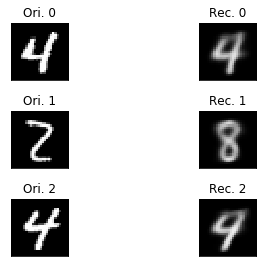

In [64]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[40:]
samples_rec,   _, _ = vae(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
for i in range(0, 3):
    plt.subplot(3,2,2*i+1)
    plt.tight_layout()
    imshow(samples[i,0])
    plt.title("Ori. {}".format(i))

    plt.subplot(3, 2, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[i])
    plt.title("Rec. {}".format(i))

Your model should be able to generate images that look similar to the samples of the MNIST dataset.
* Run the code
* Describe what you see

RuntimeError: shape '[-1, 28, 28]' is invalid for input of size 176

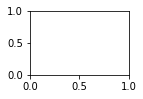

In [65]:
for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae.sampling(n=2).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])

In [68]:
vae.sampling().shape
print(vae)

CVAE(
  (encoder): Encoder(
    (mlp): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
    )
    (linear_mu): Linear(in_features=256, out_features=2, bias=True)
    (linear_lvar): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


### Training CVAE
We optimize in the following the CVAE (simpy run the code).

In [98]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]
latent_dim = 2
cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True )

cvae = cvae.to(device)
optimizer = optim.Adam(cvae.parameters())


def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device).float()
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(x, y)
        loss = loss_function(recon_batch, x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * train_loader.batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
    
    
# Training of CVAE
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 2 [0/60000 (0%)]	Loss: 34884.332031
Train Epoch: 2 [12800/60000 (21%)]	Loss: 12095.222656
Train Epoch: 2 [25600/60000 (43%)]	Loss: 10899.403320
Train Epoch: 2 [38400/60000 (64%)]	Loss: 10617.322266
Train Epoch: 2 [51200/60000 (85%)]	Loss: 10781.559570
====> Epoch: 1 Average loss: 179.4474
Train Epoch: 3 [0/60000 (0%)]	Loss: 10685.956055
Train Epoch: 3 [12800/60000 (21%)]	Loss: 10046.616211
Train Epoch: 3 [25600/60000 (43%)]	Loss: 9863.809570
Train Epoch: 3 [38400/60000 (64%)]	Loss: 9997.564453
Train Epoch: 3 [51200/60000 (85%)]	Loss: 9521.779297
====> Epoch: 2 Average loss: 152.7351
Train Epoch: 4 [0/60000 (0%)]	Loss: 9752.375000
Train Epoch: 4 [12800/60000 (21%)]	Loss: 9733.822266
Train Epoch: 4 [25600/60000 (43%)]	Loss: 9679.668945
Train Epoch: 4 [38400/60000 (64%)]	Loss: 9826.556641
Train Epoch: 4 [51200/60000 (85%)]	Loss: 9503.099609
====> Epoch: 3 Average loss: 147.4371
Train Epoch: 5 [0/60000 (0%)]	Loss: 9374.677734
Train Epoch: 5 [12800/60000 (21%)]	Loss: 9453.62793

### Sanity Check CVAE
Check whether your CVAE is able to reconstruct certain images when conditioned on the label (simply run the code).
* Is there a difference to the standard VAE?

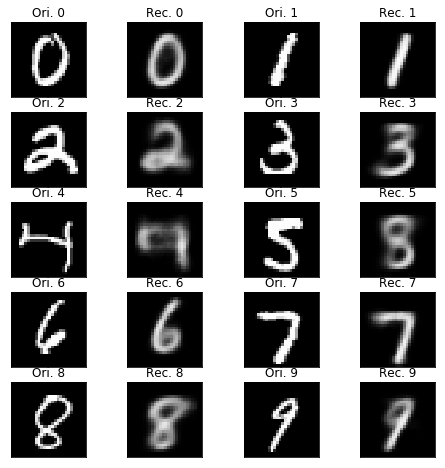

In [104]:
x,l = next(iter(train_loader))
plt.figure(figsize=(8,8))
for i in range(0, 10):
    x_one_label = x[l==i][:2]

    samples = x_one_label[:1].to(device)
    labels= i* torch.ones(1).type(torch.float).to(device)
    plt.subplot(5,4,2*i+1)
    #plt.tight_layout()
    imshow(samples[0,0].cpu())
    plt.title("Ori. {}".format(i))
    
    samples_rec, _, _ = cvae(samples, c = labels)
    samples_rec = samples_rec.detach().cpu().view(-1,28,28)

    plt.subplot(5, 4, 2*i+2)
    #plt.tight_layout()
    imshow(samples_rec[0])
    plt.title("Rec. {}".format(i))

Check whether your CVAE is able to generate images from the MNIST dataset distribution by sampling from the latent space and decode these latent codes (simply run the code).
* How do the generated digits compare to those of the VAE?
* Can you imagine why differences could arise?

RuntimeError: shape '[-1, 28, 28]' is invalid for input of size 2

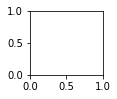

In [105]:
for i in range(0, 10):
    plt.subplot(3,4,i+1)
    label = i* torch.ones(2).type(torch.long)
    sample = cvae.sampling(n=2, c=label).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Cond. {}".format(i))

## Task 2: Visualisation of Latent Space of VAE


### Visualisation of output of decoder
Make sure you use the VAE trained with $2$ latent dimensions.

* Illustrate the 2 dimensional latent space by showing decoder output for different values in the latent space (see example on exercise sheet).

In [ ]:
########
# TODO #
########

### Visualisation of latent space
In the following, you should visualize the latent space directly.
* Make a scatter plot in latent space, where each plotted point represents the mean of the latent code of a single image from the MNIST dataset. Color the points according to the image label.
* What kind of shape should ideally arise?
* What do you see in reality?

In [ ]:
########
# TODO #
########

### Weaknesses of the VAE
* Find from your plot coordinates in the latent space that migh cause problems to the VAE if you decode this points. Explain your reasoning.
* Illustrate the decoding of one of these points.
* Describe what you see.

In [ ]:
########
# TODO #
########

## Task 3: Visualisation of Latent Space of CVAE

Make sure you use the CVAE trained with $2$ latent dimensions.

### Visualisation of Latent Space via Decoder

Repeat task 2 for the CVAE: 
* Illustrate the 2 dimensional latent space by showing the output of the decoder for different values in the latent space (see example on exercise sheet).
* Make two or three of these plots, each conditioned on a fixed label.

In [ ]:
########
# TODO #
########

### Visualisation of Latent Space via Decoder
* Repeat the scatter plot from Task 2. For each sample, use the correct label as the condition. Color the points according to the label.
* What difference do you see, compared to the standard VAE?
* How to you explain this?
* What does this mean for 'bad samples', as observed in Task 2?


In [ ]:
########
# TODO #
########

## Task 4: Generative Classifier
We define our classifier as maximum a posteriori estimator and expand according to Bayes rule:

$$ \hat y= \arg \max_y p(y \mid x) = \arg \max_y \frac{p(x \mid y)p(y)}{p(x)} = \arg \max_y \log p(x \mid y).$$

where the last identity makes use of the fact that $p(y)=1/10$ is constant for all MNIST labels. We can approximate $\log p(x \mid y)$ by running the CVAE with each label $y$ in turn (see first section for formula). Use this approximation to construct a classifier. Evaluate the accuracy of this classifier on the test dataset. Note that the network was never trained as classifier, but is still able to perform the task.

In [ ]:
########
# TODO #
########